# Entrenamiento y análisis de YOLO en el dataset de piccolo
_Santiago Prieto Núñez_

#### Objetivo
En este Jupiter Notebook utilizaremos yolos-base de hugging face como modelo
preentrenado para la detección de polipos en imágenes del dataset de Piccolo.

Pasos a seguir:
1. Procesar el dataset de piccolo y hacer un análisis exploratorio de los datos
2. Modificar el modelo de yolos-base para tener solo las bbox de salida
3. Entrenar el modelo de hugging face con los nuevos datos
4. Analizar el rendimiento del modelo

## Piccolo dataset

En este dataset es el que usaremos, es un dataset muy completo con máscaras binarias 
y metadatos de cada pólipo, además está ya dividio en test train y validation
ya que hay grupos de imágenes del mismo pólipo. Por lo que **seguiremos el split original** 
del dataset **para comparar los resultado**s con el del estudio original

**Analiazaremos el datset creado**, **obteniendo** datos del mismo como **las bbox** del pólipo

In [26]:
from utils import ImageDatasetProcessor as idp
import os

json_path = "datasets/piccolo_dataset/piccolo_dict.json"

# paths del dataset
paths_img = [
    # train paths
    ("datasets/piccolo_dataset/test/polyps",                    # polyps
     "datasets/piccolo_dataset/test/masks",                     # masks
     "datasets/piccolo_dataset/test/void", "test"  ,            # voids
     "datasets/piccolo_dataset/listado_WL-NBI_Piccolo.csv"),    # light type

    # test paths
    ("datasets/piccolo_dataset/train/polyps",
     "datasets/piccolo_dataset/train/masks",
     "datasets/piccolo_dataset/train/void", "train",
     "datasets/piccolo_dataset/listado_WL-NBI_Piccolo.csv"),

    # validation paths
    ("datasets/piccolo_dataset/validation/polyps",
     "datasets/piccolo_dataset/validation/masks",
     "datasets/piccolo_dataset/validation/void", "validation",
     "datasets/piccolo_dataset/listado_WL-NBI_Piccolo.csv")]

# inicializamos el dataset con su nombre y fichero de formatos de imagen
dt_Piccolo = idp(target_resolution=(400, 240), dataset_name="Piccolo",
                     json_path=json_path)

# procesamos el dataset si no existe el json
if not os.path.isfile(json_path):
    for path in paths_img:
        print(f"procesando conjunto: {path[3]}")
        dt_Piccolo.load_dataset(path[0], path[1], voids_path=path[2], 
                                split=path[3], light_csv=path[4])

#### Análisis del dataset
Como podemos ver es un dataset muy ordenado, con una cantidad representativa de
imágenes NBI por lo que es adecuado para el entrenamiento en ambos tipos de luz 
(WL, NBI).

Además podemos observar que es un dataset con una distribución de los pólipos
más o menos descentralizada.

In [27]:
dt_Piccolo.print_summary()

Total imágenes: 3433
Composición del dataset:
Resoluciónes: total distintas resoluciones 2
	480x854: 1972	1080x1920: 1461

Tipos de luz:
	WL: 2131	NBI: 1302

Splits:
	test: 333	train: 2203	validation: 897

Canales:
	polyp_RGB: 3433	mask_L: 3433	void_L: 3433

Volumen medio de los pólipos respecto a la imagen:	20.195122875106236%
Distancia media del centro del pólipos al centro de la imagen:	55.30091482169522px


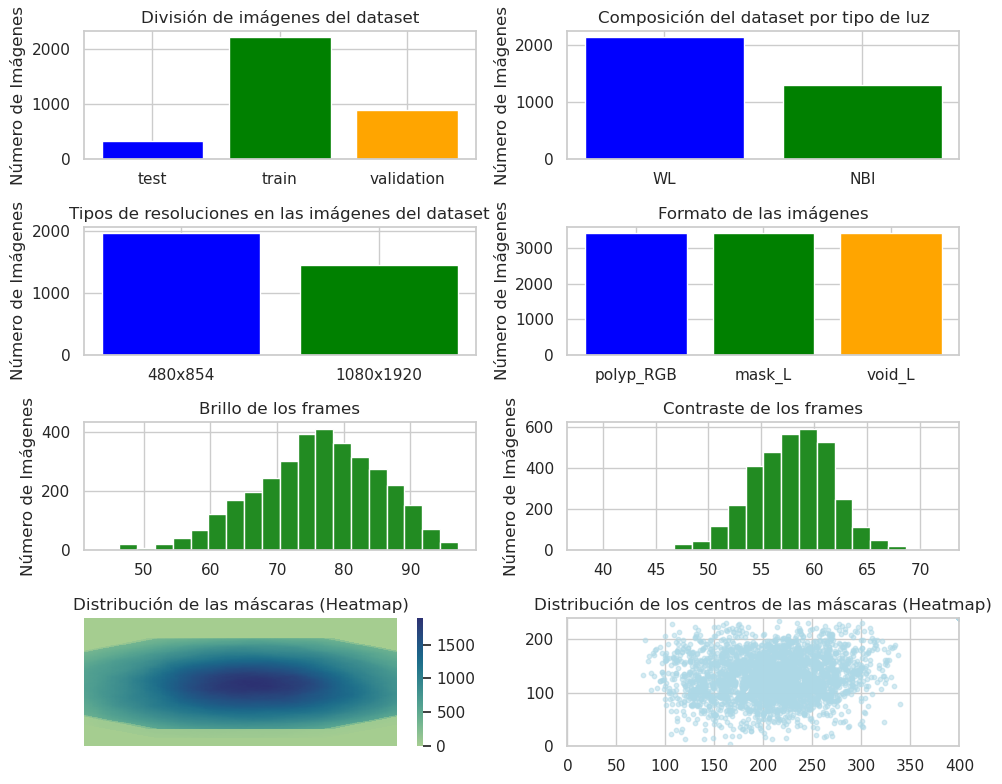

In [28]:
dt_Piccolo.graph_summmary()

Finalmente veamos una muestra de una imágen aleatoria y su aspecto con la bbox

Imagen 032_VP30_frame4592.png	bbox: (136, 0, 313, 479)


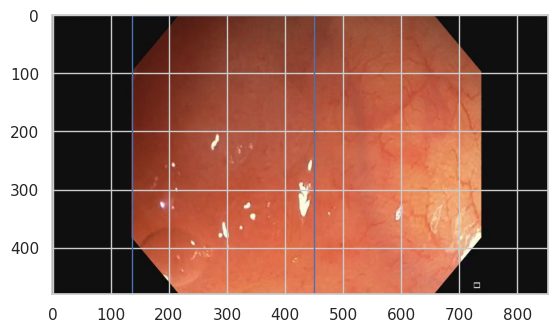

In [29]:
import random

# mostramos aleatoriamente una imágen del dataset
rand_key = random.choice(list(dt_Piccolo.dict.keys()))
dt_Piccolo.show_image(rand_key)


## Entrenamiento de YOLO

Para esta segunda entrenaremos el modelo de [yolos-base](https://huggingface.co/hustvl/yolos-base)
con las imágenes del dataset de Piccolo, con la peculiaridad que trataremos con 
un modelo modificado para devolver solo las bboxes.

#### Pasos del entrenemiento
1. **Modificaremos el modelo** para entrenar y devolver tan solo las bboxes ya que 
YOLO tiene dos MLP de salida que recogen los mismos datos del encoder, estas
son las **dos salidas de yolo** que son el clasificador de clases de COCO y las
bbox que localizan este objeto, **solo nos interesa la segunda**

2. **Preparar todo para el entrenamiento**, esto son elementos como el 
optimizador y la función de pérdida además de juntar definitivamente los datos
en los splits adecuados y DataLoaders para usarlos en la función de entrenamiento

3. **Entrenar** el modelo y ir obteniendo datos del rendimiento del mismo para
poder mostrarlos más adelante

### Modificar el modelo para Fine-Tunning
Tenemos un modelo de **yolos-base** con una arquitectura ViT y la salida del decoder
se da a dos MLP aisladas, estas son las dos salidas:

1. MLP de dos capas con una salida de claisificacion de 92 clases de COCO
2. MLP de dos capas pero la salida es un vector de 4 elementos con las coordenadas
en formato "center" o YOLO de la bbox **(cx,cy,w,h)**

En ambos casos el modelo de **Yolo hará 100 predicciones** de cajas y de clases.

Como queremos simplemente una prediccion de bbox, debemos hacer dos cosas
- Congelar la MLP correspondiente a la clasificacion de COCO ya que **solo queremos la obtención de las bboxes** con las que detectamos los pólipos.
- Reemplazara la capa de detección de bboxes por una que solo obtenga 1 prediccion
haciendo el modelo **más eficiente y sencillo**. Algo que puede ayudar debido a
la baja variabilidad de las imágenes de pólipos que son muy parecidas entre si.

Ya que estamos creando una nueva cabeza de predicción en para el modelo de yolos,
 congeelamos el modelo para **hacer un fine tunning de esta última capa** y ver que 
 tal funciona.

Para ello crearemos una clase con el modelo de Yolos personalizado como indica 
la [documentación de hugging face](https://huggingface.co/docs/transformers/custom_models).
y en ella personalizaremos las siguientes preferencias:
- **Eliminar class_labels_classifier**: Se borra y se reemplaza por None.
- El **forward() solo devuelve las bboxes**: Se quita la salida de clasificación.
- El modelo ahora **solo hace backpropagation en las bounding boxes**

In [30]:
from transformers import YolosForObjectDetection
import torch.nn as nn
import torch

# Creamos una cabeza de deteccion siguiendo el formato de YOLO
class BBoxMLP(nn.Module):
    def __init__(self, in_features=384, hidden_dim=384, out_features=4):
        super(BBoxMLP, self).__init__()
        
        # Creamos la MLP de detección
        self.mlp = nn.Sequential(
            nn.Linear(in_features, hidden_dim),     # capa de entrada
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),      # capa intermedia
            nn.ReLU(),
            nn.Linear(hidden_dim, out_features)     # capa de salida
        )

    # debemos definir el forward ya que heredamos de nn.Module
    def forward(self, x):
        return self.mlp(x)  # ejecuta la sentencia de mlp

# Modificamos la arquitectura ViT-small para detectar con la cabeza BBoxMLP
class ViTs4Detection(nn.Module):
    # Usamos el constructor original pero eliminando la MLP de clasificación
    # Esto evita que el modelo actualize en el backward esa MLP
    def __init__(self, vit_model, bbox_head):
        super(ViTs4Detection, self).__init__()  # iniciamos la clase padre antes de nada
        
        self.vit = vit_model
        self.head_bbox = bbox_head

    def forward(self, x):
        # x es la entrada de la imagen
        features = self.vit(x)      # ejecutamos la vit
        # forma de salida (batch_size, 384) -> ya tenemos los CLS
        bboxes = self.head_bbox(features)

        return {'pred_bboxes': bboxes}

#### Preparar el entrenamiento
Una vez modificado el modelo solo debemos preparar el entrenamiento, es decir:
- Definir los dataloders
- Cargar el modelo personaliazdo
- Definir las funciones de pérdida y optimizadores
- Definir una fuinciñon de entrenamiento

Utilizaremos el **optimizador Adalain** ya que es el usado en Yolos-base y la 
**loss fuction smooth_l1_loss** para las bbox de la salida ya que es información contínua

#### Funcion de entrenamiento

Ya que para utilizar imégenes el proceso es algo largo ya que hay que cargarlas,
 transformarlas y guardaralas en la GPU, independientemente de si es para train
 validation o test.
 
 Vamos a crear una **función** para poder **pasar las imágenes por el modelo**
 independientemente de si es para entrenar, validar o test y así evitamos repetir código


In [31]:
from PIL import Image
import torch
from utils import yolo_bbox_iou
import math


def try_model(data_loader, device, model, transform, train_mode=False, 
              loss_fn=None, optimizer=None, img_size=(240, 240)):
    """
    Esta funcion se encarga de correr en el modelo el dataloader proporcionado
    aplicando a las imagenes la transformación dada, ejecutando todo en el dispositivo
    indicado y entrenandolo si esta indicado. 
    Si NO se indica entrenar, funciona como una validacion
    """

    # Para seguir el accurracy y el loss del modelo
    loss_try = 0
    IoU_try = 0

    for batch in data_loader:
        # Primero debemos cargar las imagen desde su path y convertirlas a tensores
        images = []
        
        # para ello cargamos las imagenes del batch en una lista
        for path in batch['path']:
            image = Image.open(path).convert('RGB') # Aseguramos 3 canales
            # guardamos la imagen transformada
            images.append(transform(image))
        
        # las convertimos en un tensor
        images = torch.stack(images)

        # Ahora procesamos las bbox que parecido a las imagenes vienen como una lista de tensores
        # por lo que las agrupamos y convertimos a un solo tensor
        bbox = torch.stack(batch['bbox']).T

        # Ahora terminamos por guardar todo en la GPU
        images = images.to(device)
        bbox = bbox.to(device)

        # forward propagation
        pred = model(images)['pred_bboxes']

        # calculamos la loss funciton
        loss = loss_fn(bbox, pred)
        
        # Si entrenamos actualizamos los pesos
        if train_mode:
            # backpropagation
            loss.backward()
            
            optimizer.step()
            optimizer.zero_grad()

        # Finalmente guardamos el error del batch para analizarlo
        loss_try += loss.item()

        # Obtenemos el valor e IoU del batch
        for pred_box, target_box in zip(pred, bbox):
            IoU_try += yolo_bbox_iou(img_size, pred_box.tolist(), target_box.tolist())

    # Obtenemos la media de error en entrenamiento
    loss_try /= len(data_loader.dataset)
    IoU_try /= len(data_loader.dataset)

    return (loss_try, IoU_try)

#### Entrenamiento

Ahora por fin pasamos a entrenar el modelo y recopilar los dátos de análisis 
para ellos obtenemos el IoU de las bboxes, ya que al ser areas en al imágen no 
podemos medir un "accuracy" tal cual.

**IoU** es una métrica usada para este
tipo de situaciones en las que se calcula: **IoU=Area_interseccion/Area_union** 
por lo que es importante tener en cuenta que **un IoU 1 es una coincidencia exacta**

In [32]:
import timm
import torch.nn as nn

# Cargamos el modelo de la librería timm
vit_S = timm.create_model('vit_small_patch16_384', pretrained=True, num_classes=0)

# creamos el modelo con la cabeza personalizada de detección
model = ViTs4Detection(vit_S, BBoxMLP())
model.train()

ViTs4Detection(
  (vit): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (norm_pre): Identity()
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=384, out_features=1152, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=384, out_features=384, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): Identity()
        (drop_path1): Identity()
        (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=384, out_features=1536, bias=True)
          (act): GELU(approximate='none')
          (drop1): Dropout(p=0.0, inplace=False)
          (fc2): Linear(in_features=1536,

In [33]:
import torch.nn as nn
from torch.optim import AdamW
import torchvision.transforms as transforms
import torch

# definimos los parametros del entrenamiento 🏃‍♂
COCO_DIR = 'datasets/COCO_2017'
NUM_EPOCH = 50              # 🔄 Numero de epocas del entrenamiento 
BATCH_SIZE = 10             # 👝 Numero de imágenes por batch
TRAIN_RES = (384, 384)      # 📷 Resolucion entreno, respetamos la proporción 16/9


# Obtener los diccionarios con formato de entrenamiento
train_loader, val_loader, test_loader = dt_Piccolo.get_dataloaders(
                                            BATCH_SIZE, use_premade_splits=True)

# definimos el optimizador y la loss function
def loss_fn(target, pred):
    return nn.functional.smooth_l1_loss(pred, target)

optimizer = AdamW(model.parameters(), lr=5e-5)

# definimos el device en que se hará el entrenamiento
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# definimos la transofrmacion para el tensor, en 256x256 ya que son patches de 16x16
transform = transforms.Compose([
    transforms.Resize(TRAIN_RES),
    transforms.ToTensor(),
])

# Estas son variables para analizar el modelo
log_epochs = 1 # cada cuantas epocas obtenemos datos del modelo
loss_hist_train = [0] * NUM_EPOCH
loss_hist_val = [0] * NUM_EPOCH
IoU_hist_train = [0] * NUM_EPOCH
IoU_hist_val = [0] * NUM_EPOCH

for epoch in range(NUM_EPOCH):  # Número de épocas
    loss_aux = 0
    IoU_aux = 0

    # 📍 Entrenamos el modelo
    model_results = try_model(train_loader, device, model, transform, 
                              train_mode=True, loss_fn=loss_fn, 
                              optimizer=optimizer, img_size=TRAIN_RES)
    # Guardamos los resultados de la época
    loss_hist_train[epoch], IoU_hist_train[epoch] = model_results

    # 💾 Validamos el modelo
    model_results = try_model(val_loader, device, model, transform, 
                              loss_fn=loss_fn, img_size=TRAIN_RES)
    loss_hist_val[epoch], IoU_hist_val[epoch] = model_results

    # mostramos como va el entrenamiento
    if epoch % log_epochs==0:
        print(f'Epoch {epoch}  Loss train {loss_hist_train[epoch]:.4f}  IoU train {IoU_hist_train[epoch]:.4f} ')
        print(f'Epoch {epoch}  Loss valid {loss_hist_val[epoch]:.4f}  IoU valid {IoU_hist_val[epoch]:.4f} ')

# 🏁 Finalmente evaluamos el modelo en test
model_results = try_model(test_loader, device, model, transform, 
                              loss_fn=loss_fn, img_size=TRAIN_RES)
loss_test, IoU_test = model_results

print("End of training!")
print("-------------------- FINAL RESULTS ------------------------")
print(f"|     - Test loss:     {loss_test}                         |")
print(f"|     - Test IoU: {IoU_test}                         |")
print("-----------------------------------------------------------")
        

Epoch 0  Loss train 0.0011  IoU train 0.3943 
Epoch 0  Loss valid 0.0015  IoU valid 0.4591 
Epoch 1  Loss train 0.0005  IoU train 0.4897 
Epoch 1  Loss valid 0.0014  IoU valid 0.4349 
Epoch 2  Loss train 0.0003  IoU train 0.5578 
Epoch 2  Loss valid 0.0012  IoU valid 0.5129 
Epoch 3  Loss train 0.0002  IoU train 0.6040 
Epoch 3  Loss valid 0.0012  IoU valid 0.4794 
Epoch 4  Loss train 0.0001  IoU train 0.6455 
Epoch 4  Loss valid 0.0012  IoU valid 0.4909 
Epoch 5  Loss train 0.0001  IoU train 0.6731 
Epoch 5  Loss valid 0.0013  IoU valid 0.4623 
Epoch 6  Loss train 0.0001  IoU train 0.6701 
Epoch 6  Loss valid 0.0012  IoU valid 0.5189 
Epoch 7  Loss train 0.0001  IoU train 0.6923 
Epoch 7  Loss valid 0.0012  IoU valid 0.4863 
Epoch 8  Loss train 0.0001  IoU train 0.6908 
Epoch 8  Loss valid 0.0011  IoU valid 0.5330 
Epoch 9  Loss train 0.0001  IoU train 0.6995 
Epoch 9  Loss valid 0.0011  IoU valid 0.5261 
Epoch 10  Loss train 0.0001  IoU train 0.7230 
Epoch 10  Loss valid 0.0011  IoU 

## Análisis de los resultados

Una vez entrenado el modelo y finalizada la obtencion de datos durante el entrenamiento,
además de disponer de los datos de test vamos a graficar los resultados y ver 
que tal ha ido el entrenamiento.

In [34]:
import json
# Primero guardamos los datos del entrenamiento terminado para su análisis
json_dict = {
    "loss_hist_train": loss_hist_train,
    "loss_hist_val": loss_hist_val,
    "IoU_hist_train": IoU_hist_train,
    "IoU_hist_val": IoU_hist_val,
    "IoU_hist_val": IoU_hist_val,
    "loss_test": loss_test,
    "IoU_test": IoU_test
}

with open("./resultados/Piccolo_ViT_S_Fine_tunning_384x384.json ", "w", encoding="utf-8") as json_file:
    json.dump(json_dict, json_file)  # `indent=4` para formato legible

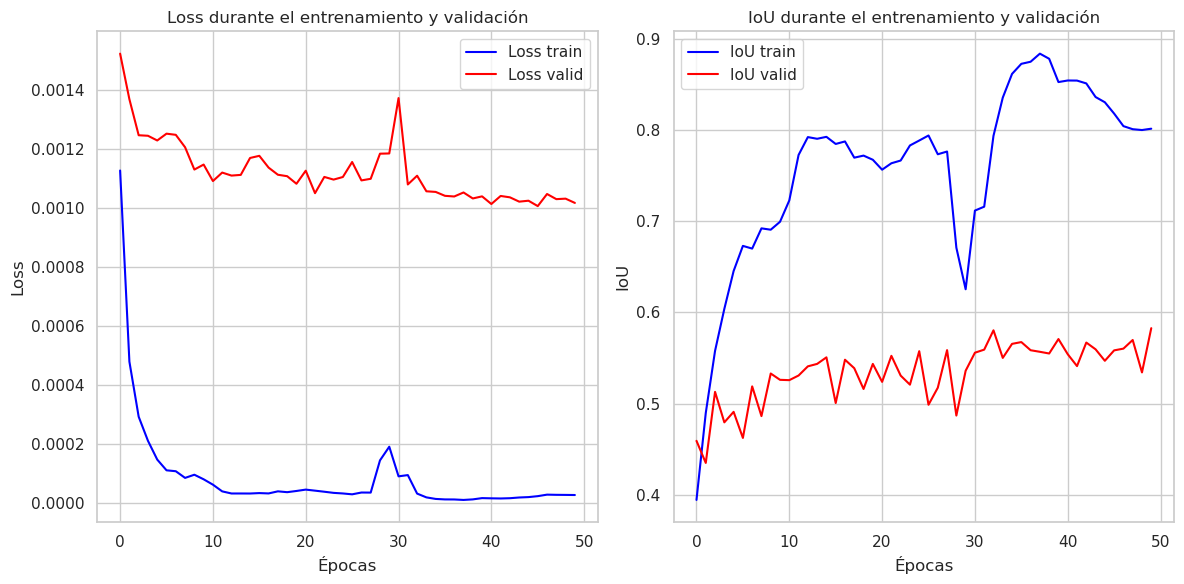

In [35]:
import matplotlib.pyplot as plt

# Graficar la evolución de la Loss durante el entrenamiento y validación
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)  # Subgráfico 1: Loss
plt.plot(range(NUM_EPOCH), loss_hist_train, label='Loss train', color='blue')
plt.plot(range(NUM_EPOCH), loss_hist_val, label='Loss valid', color='red')
plt.title('Loss durante el entrenamiento y validación')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()

# Graficar la evolución de la IoU durante el entrenamiento y validación
plt.subplot(1, 2, 2)  # Subgráfico 2: IoU
plt.plot(range(NUM_EPOCH), IoU_hist_train, label='IoU train', color='blue')
plt.plot(range(NUM_EPOCH), IoU_hist_val, label='IoU valid', color='red')
plt.title('IoU durante el entrenamiento y validación')
plt.xlabel('Épocas')
plt.ylabel('IoU')
plt.legend()

# Mostrar ambas gráficas
plt.tight_layout()
plt.show()